# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore");


from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve, precision_recall_curve 
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import itertools
from sklearn.utils import shuffle

In [137]:
#Открываю датасет и смотрю пропуски 
data = pd.read_csv('/datasets/Churn.csv')
display(data)
print(data.isna().sum())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


In [138]:
#Удаляю дубликаты и ненжные для обучения столбцы
data = data.drop_duplicates()
data = data.drop(['CustomerId', 'Surname'], axis=1)
data = data.drop(['RowNumber'], axis=1)

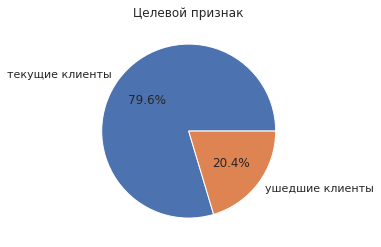

In [139]:
# Целевой признак
labels = ['текущие клиенты', 'ушедшие клиенты']
Exited = data.groupby('Exited')['CreditScore'].count()
plt.pie(Exited, labels=labels, autopct='%1.1f%%');
plt.title('Целевой признак');
plt.show();

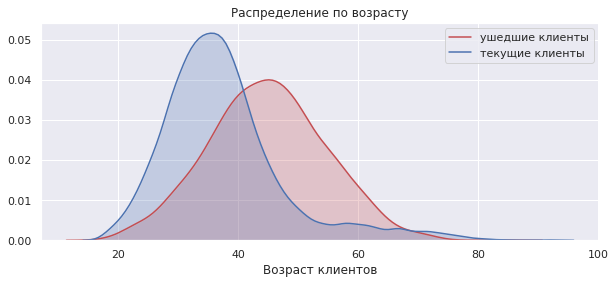

In [140]:
#Другой признак
sns.set(rc={'figure.figsize':(10,4)})
ax = sns.kdeplot(data[data['Exited']==1].Age , shade=True, color='r', label='ушедшие клиенты')
ax = sns.kdeplot(data[data['Exited']==0].Age , shade=True, color='b', label='текущие клиенты')
plt.title('Распределение по возрасту')
plt.xlabel('Возраст клиентов');

Проверил также другие признаки, но этот показывает большее расхождение и станет первым правилом в дереве решений.

In [141]:
#Пропущенные значения заполню медианой
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())
data['Tenure'] = data['Tenure'].astype('int64')

In [142]:
#Категориальные значения кодируем методом оне
data_ohe = pd.get_dummies(data, drop_first=True)

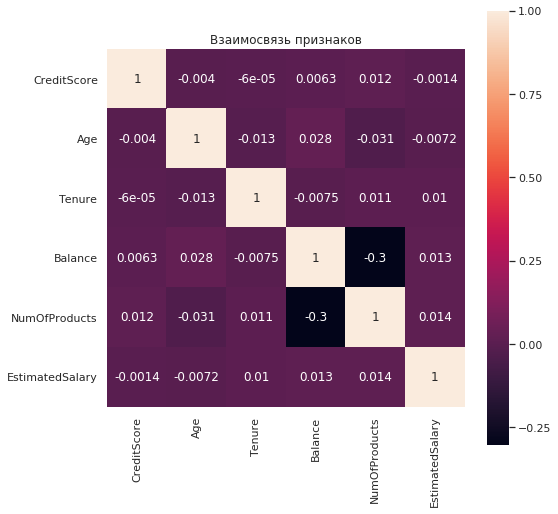

In [143]:
#Корреляция признаков
columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data_ohe[columns].corr(), square=True, ax=ax, annot = True);
plt.title('Взаимосвязь признаков');

Сильной корреляции не обнаружено, другие столбцы удалять не нужно

# 2. Исследование задачи

In [144]:
#Разделим датасет на валидационный, тест и обучение
data_train, data_valid = train_test_split(data_ohe, test_size=0.25, random_state=12345)
data_valid, data_test = train_test_split(data_valid,test_size = 0.5, random_state=12345)

#Обучающая выборка
features_train = data_train.drop(['Exited'], axis=1)
target_train = data_train['Exited']

#Валидационная выборка
features_valid = data_valid.drop(['Exited'], axis=1)
target_valid = data_valid['Exited']

#Тестовая выборка
test_features = data_test.drop(['Exited'], axis=1)
test_target = data_test['Exited']

print('Размер обучающей выборки:', data_train.shape[0],'объектов')
print('Размер валидационной выборки:', data_valid.shape[0],'объекта')
print('Размер тестовой выборки:',data_test.shape[0],'объекта')

Размер обучающей выборки: 7500 объектов
Размер валидационной выборки: 1250 объекта
Размер тестовой выборки: 1250 объекта


In [145]:
#Датафрейм для сохранения результатов
metric = {'accuracy':0, 'precision':0, 'recall':0, 'f1':0, 'auc_roc':0}
data_metric = pd.DataFrame.from_dict(metric, orient= 'index').rename(columns={0:'KNN'})

def metric_result(predictions, target, prefix):
    accuracy = accuracy_score(target, predictions)
    precision = precision_score(target, predictions)
    recall = recall_score(target, predictions)
    f1 = f1_score(target, predictions)
    auc_roc = roc_auc_score(target, predictions)
    data_metric[prefix] = 0
    data_metric.loc['accuracy', prefix] = accuracy
    data_metric.loc['precision', prefix] = precision
    data_metric.loc['recall', prefix] = recall
    data_metric.loc['f1', prefix] = f1
    data_metric.loc['auc_roc', prefix] = auc_roc
    
    return data_metric

In [146]:
#Проверяю модели
model_1 = KNeighborsClassifier()
model_1.fit(features_train, target_train)
predictions = model_1.predict(features_valid)
metric_result(predictions, target_valid, 'KNN').head()

,KNN
accuracy,0.767200
precision,0.340909
recall,0.114068
f1,0.170940
auc_roc,0.527652


In [147]:
model_2 = GaussianNB()
model_2.fit(features_train, target_train)
predictions = model_2.predict(features_valid)
metric_result(predictions, target_valid, 'Bayes').head()

,KNN,Bayes
accuracy,0.767200,0.767200
precision,0.340909,0.240741
recall,0.114068,0.049430
f1,0.170940,0.082019
auc_roc,0.527652,0.503945


In [148]:
model_3 = LogisticRegression(random_state=12345)
model_3.fit(features_train, target_train)
predictions = model_3.predict(features_valid)
metric_result(predictions, target_valid, 'Logical_regression').head()

,KNN,Bayes,Logical_regression
accuracy,0.767200,0.767200,0.779200
precision,0.340909,0.240741,0.341463
recall,0.114068,0.049430,0.053232
f1,0.170940,0.082019,0.092105
auc_roc,0.527652,0.503945,0.512938


In [149]:
model_4 = DecisionTreeClassifier(max_depth=3, random_state=12345)
model_4.fit(features_train, target_train)
predictions = model_4.predict(features_valid)
metric_result(predictions, target_valid, 'tree_class').head()

,KNN,Bayes,Logical_regression,tree_class
accuracy,0.767200,0.767200,0.779200,0.839200
precision,0.340909,0.240741,0.341463,0.792453
recall,0.114068,0.049430,0.053232,0.319392
f1,0.170940,0.082019,0.092105,0.455285
auc_roc,0.527652,0.503945,0.512938,0.648551


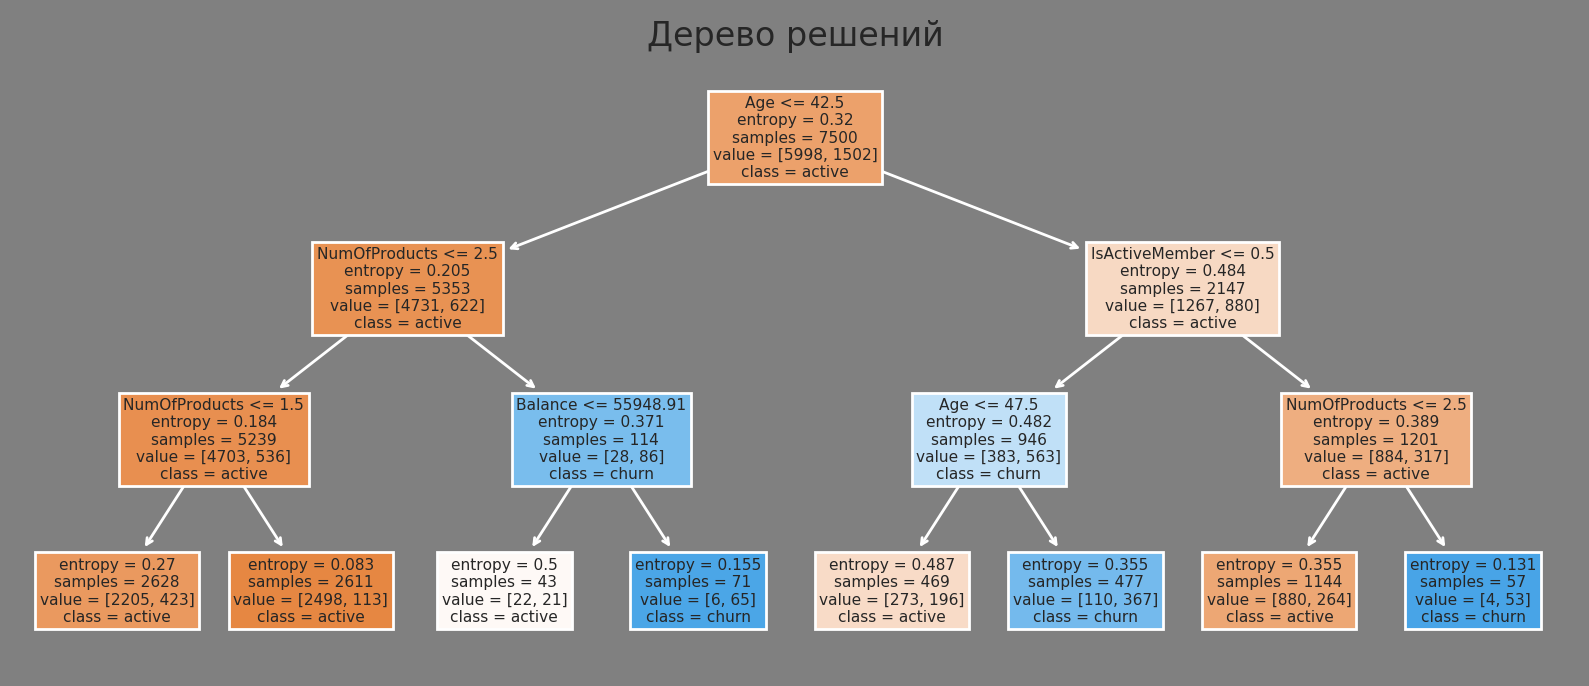

In [150]:
fn=features_train.columns
cn=['active', 'churn']
fig, axes = plt.subplots(dpi=200, facecolor='gray');
tree.plot_tree(model_4,
              feature_names= fn,
              class_names=cn,
              filled = True)
plt.title('Дерево решений');

In [151]:
#Тюнинг модели
param_dist = {'n_estimators': range(10,51,10),
             'max_depth': range(1,18,2),
             'min_samples_split': range(5,55,10),
             'min_samples_leaf': range(5,55,10)
             }

In [152]:
#model = RandomForestClassifier()
#grid = GridSearchCV(model, param_dist, verbose=1, cv=5)
#grid.fit(features_train, target_train)
#grid.best_params_


Лучшая модель имеет параметры:
   n_estimators: 30
   max_depth: 15,
   min_samples_split: 15
   min_samples_leaf: 5

In [156]:
model_5 = RandomForestClassifier(n_estimators=30, max_depth=15, min_samples_leaf=5,
                                 min_samples_split=15,
                                 random_state=12345)
model_5.fit(features_train, target_train)
predictions = model_5.predict(features_valid)
metric_result(predictions, target_valid, 'random_forest').head()

,KNN,Bayes,Logical_regression,tree_class,random_forest
accuracy,0.767200,0.767200,0.779200,0.839200,0.862400
precision,0.340909,0.240741,0.341463,0.792453,0.827338
recall,0.114068,0.049430,0.053232,0.319392,0.437262
f1,0.170940,0.082019,0.092105,0.455285,0.572139
auc_roc,0.527652,0.503945,0.512938,0.648551,0.706473


# 3. Борьба с дисбалансом

In [159]:
model_6 = RandomForestClassifier(n_estimators=30, max_depth=15, min_samples_leaf=5,
                                 min_samples_split=15,
                                 class_weight='balanced',
                                 random_state=12345)
model_6.fit(features_train, target_train)
predictions = model_6.predict(features_valid)
metric_result(predictions, target_valid, 'random_forest_balanced').head()

,KNN,Bayes,Logical_regression,tree_class,random_forest,random_forest_balanced
accuracy,0.767200,0.767200,0.779200,0.839200,0.862400,0.847200
precision,0.340909,0.240741,0.341463,0.792453,0.827338,0.628571
recall,0.114068,0.049430,0.053232,0.319392,0.437262,0.669202
f1,0.170940,0.082019,0.092105,0.455285,0.572139,0.648250
auc_roc,0.527652,0.503945,0.512938,0.648551,0.706473,0.781916


In [160]:
#Увеличиваю данные в датасете
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

In [164]:
model_6 = RandomForestClassifier(n_estimators=30, max_depth=15, min_samples_leaf=5,
                                 min_samples_split=15,
                                 class_weight='balanced',
                                 random_state=12345)
model_6.fit(features_upsampled, target_upsampled)
predictions = model_6.predict(features_valid)
metric_result(predictions, target_valid,'upsample').head()

,KNN,Bayes,Logical_regression,tree_class,random_forest,random_forest_balanced,upsample
accuracy,0.767200,0.767200,0.779200,0.839200,0.862400,0.847200,0.829600
precision,0.340909,0.240741,0.341463,0.792453,0.827338,0.628571,0.582237
recall,0.114068,0.049430,0.053232,0.319392,0.437262,0.669202,0.673004
f1,0.170940,0.082019,0.092105,0.455285,0.572139,0.648250,0.624339
auc_roc,0.527652,0.503945,0.512938,0.648551,0.706473,0.781916,0.772166


Как видим, лучшие параметры для модели случайного леса с сбалансированными весами.

# 4. Тестирование модели

In [168]:
best_model = RandomForestClassifier(n_estimators=30, max_depth=15, min_samples_leaf=5,
                                 min_samples_split=15,
                                 class_weight='balanced',
                                 random_state=12345)
best_model.fit(features_train, target_train);
predictions = best_model.predict(test_features)
metric_result(predictions, test_target, 'test').head()

,KNN,Bayes,Logical_regression,tree_class,random_forest,random_forest_balanced,upsample,test
accuracy,0.767200,0.767200,0.779200,0.839200,0.862400,0.847200,0.829600,0.837600
precision,0.340909,0.240741,0.341463,0.792453,0.827338,0.628571,0.582237,0.616949
recall,0.114068,0.049430,0.053232,0.319392,0.437262,0.669202,0.673004,0.669118
f1,0.170940,0.082019,0.092105,0.455285,0.572139,0.648250,0.624339,0.641975
auc_roc,0.527652,0.503945,0.512938,0.648551,0.706473,0.781916,0.772166,0.776788


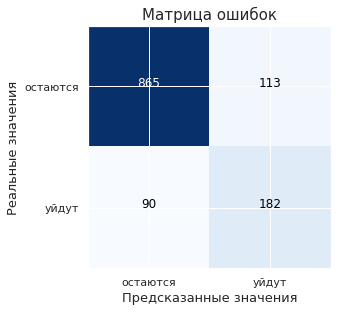

In [174]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('Реальные значения', fontsize=13)
    plt.xlabel('Предсказанные значения', fontsize=13)
    
predictions = best_model.predict(test_features)
cnf_matrix = confusion_matrix(test_target, predictions)
plt.figure(figsize=(5,4))
plot_confusion_matrix(cnf_matrix, classes=['остаются', 'уйдут'])
plt.title('Матрица ошибок', fontsize=15)
plt.show()

### Вывод
Модель показывает f1 0, 648. Матрица показывает небольшое значение ложных предсказаний.